In [1]:
import tabula
import requests
import datetime
import pandas as pd
import json
import os
from dateutil import parser
from datetime import datetime
import numpy as np

from filecmp import cmp 
from pathlib import Path

### Download the Covid-19 case data from San Diego County

In [2]:
url = 'https://www.sandiegocounty.gov/content/dam/sdc/hhsa/programs/phs/Epidemiology/COVID-19%20Summary%20of%20Cases%20by%20Zip%20Code.pdf'
pdf= requests.get(url)
with open(f'./Data/Total_Count/Temp/covid19_in_sd_{datetime.now().strftime("%d-%b-%Y-%H_%M_%S")}.pdf','wb') as f:
    f.write(pdf.content)


In [3]:
def tabula_convert_pdf_to_df(pdf):
    #Because pdfs are saved with different dateformat in the name, use different method.
    try:
        pdf_download_date = datetime.strptime("".join(str(pdf.name).split('_')[3:]).split('.')[0],"%d-%b-%Y-%H%M%S") 
    except ValueError as e:
        pdf_download_date = datetime.strptime("".join(str(pdf.name).split('_')[3:]).split('.')[0],"%Y-%M-%d") 
    print(pdf_download_date.date())
    print(f'Converting {pdf} to df')
    #Since they keep changing the format of the pdf we need to read pdf case by case.
    if  pdf_download_date < datetime.strptime('23-04-2020', "%d-%m-%Y"):
        raw_data = tabula.read_pdf(pdf,stream=False,pages=1)[0]
        #data extraction and munging
        df = raw_data.dropna(how='all').reset_index().drop(columns=['index'])
        text_data = df.columns[0]
        df.columns = df.iloc[0].values
        df = df.drop(axis=0, labels=0).rename(columns={'Count':'CaseCount'})
        title = text_data.split('\r')[-1]    
        count_data= pd.DataFrame({
                  'ZipCode' : pd.concat([df.iloc[:,0].astype(str),
                                         df.iloc[:,2].astype(str)]), 

                   'CaseCount': pd.concat([df.iloc[:,1],
                                           df.iloc[:,3]])
                 })
        count_data['TotalCount'] = count_data[(count_data['ZipCode']=='Total') | (count_data['ZipCode']=='TOTAL') ]['CaseCount'].values[0]
        count_data = count_data[(count_data['ZipCode'] != 'Total') & (count_data['ZipCode'] != 'TOTAL')]
        count_data['RatePer100000'] =  "Unknown"
        
    elif  pdf_download_date.date() == datetime.strptime('29-06-2020', "%d-%m-%Y").date():
        text,raw_data= tabula.read_pdf(downloaded_pdf,multiple_tables=True)
        text_data= text.columns[0]
        title = text_data.split('\r')[-1]
        # Because Count.1 is being coverted as float with NAN..have to do this ugly covnersion.
        raw_data['Count.1'] = raw_data['Count.1'].fillna(-1)
        raw_data['Count.1'] = raw_data['Count.1'].astype(int)
        raw_data['Count.1'] = raw_data['Count.1'].astype(str)
        raw_data['Count.1'] = raw_data['Count.1'].replace('-1',np.nan)
        
        cond = raw_data['Zip Code.1'].isnull()
        raw_data.loc[cond, ['Count.1', 'Zip Code.1']] = raw_data.loc[cond, ['Zip Code.1', 'Count.1']].values  
        
        cond2 = raw_data['Count.1'].isnull()
        raw_data.loc[cond2, ['Rate per 100,000*.1', 'Count.1']] = raw_data.loc[cond, ['Count.1', 'Rate per 100,000*.1']].values 
        
        cond3 = raw_data['Rate per 100,000*.1'].isnull()
        raw_data.loc[cond2, ['Unnamed: 0', 'Rate per 100,000*.1']] = raw_data.loc[cond, ['Rate per 100,000*.1', 'Unnamed: 0']].values 
        
        raw_data=raw_data.dropna(axis=0, how='all')
        
        count_data= pd.DataFrame({
                  'ZipCode' : pd.concat([raw_data.iloc[:,0].astype(str),
                                         raw_data.iloc[:,3].astype(str)]),
                  'RatePer100000' : pd.concat([raw_data.iloc[:,2].astype(str),
                                         raw_data.iloc[:,5].astype(str)]),
                   'CaseCount': pd.concat([raw_data.iloc[:,1],
                                           raw_data.iloc[:,4]])
                 })
        count_data = count_data.reset_index(drop=True)
        total_count =  count_data[(count_data['ZipCode']=='San Diego County Total') | (count_data['ZipCode']=='San Diego County')]['CaseCount'].values[0] 
        total_count = int("".join(x for x in total_count if x.isdigit()))
        count_data['TotalCount'] = total_count
        count_data = count_data[(count_data['ZipCode'] != 'San Diego County Total') & (count_data['ZipCode'] != 'San Diego County')]
        count_data['RatePer100000'] =  count_data['RatePer100000'].replace('**',"Unknown")
        count_data['CaseCount'] =count_data['CaseCount'].fillna(-1)
        count_data['CaseCount'] =count_data['CaseCount'].astype(int)
        count_data['CaseCount'] =count_data['CaseCount'].astype(str)
        count_data['CaseCount'] =count_data['CaseCount'].replace('-1',np.nan)
        
    elif  pdf_download_date.date() == datetime.strptime('02-07-2020', "%d-%m-%Y").date():
        raw_data = tabula.read_pdf(pdf,stream=True,pages=1, lattice=True)
        text_data = raw_data[0].columns[0]
        title = text_data.split('\r')[-1] 
        raw_data[2]['Count'] = raw_data[2]['Count'].str.replace(',','')
        count_data = pd.concat([raw_data[1], raw_data[2]],axis = 0)
        count_data = count_data.rename(columns={'Zip Code':'ZipCode', 'Count':'CaseCount', 'Rate per 100,000*': "RatePer100000"})
        count_data = count_data.dropna(how='all')
        total_count =  count_data[(count_data['ZipCode']=='San Diego County Total') | (count_data['ZipCode']=='San Diego County')]['CaseCount'].values[0] 
        total_count = int("".join(x for x in total_count if x.isdigit()))
        count_data['TotalCount'] = total_count
        count_data = count_data[(count_data['ZipCode'] != 'San Diego County Total') & (count_data['ZipCode'] != 'San Diego County')]
        count_data['RatePer100000'] =  count_data['RatePer100000'].replace('**',"Unknown")
        
    else:  
        raw_data = tabula.read_pdf(pdf,stream=True,pages=1, lattice=True)
        text_data = raw_data[0].columns[0]
        title = text_data.split('\r')[-1] 
        count_data = pd.concat([raw_data[1], raw_data[2]],axis = 0)
        count_data = count_data.rename(columns={'Zip Code':'ZipCode', 'Count':'CaseCount', 'Rate per 100,000*': "RatePer100000"})
        count_data = count_data.dropna(how='all')
        
        total_count =  count_data[(count_data['ZipCode']=='San Diego County Total') | (count_data['ZipCode']=='San Diego County')]['CaseCount'].values[0] 
        total_count = int("".join(x for x in total_count if x.isdigit()))
        count_data['TotalCount'] = total_count
        count_data = count_data[(count_data['ZipCode'] != 'San Diego County Total') & (count_data['ZipCode'] != 'San Diego County')]
        count_data['RatePer100000'] =  count_data['RatePer100000'].replace('**',"Unknown")
        

    #parse dates
    dates = []
    for _ in title.split():
        try:
            dates.append(parser.parse(_, fuzzy=True))
        except Exception as e:
            pass
    date = dates[0]

    updated_time = datetime.combine(dates[1],datetime.time(dates[2]))

    count_data.dropna(how='any', inplace=True)
    count_data['ReportedDate'] = date 
    count_data['UpdatedDatetime'] = updated_time
    try:
        count_data['CaseCount'] = count_data['CaseCount'].astype('int16')
    except : 
        count_data['CaseCount'] = count_data['CaseCount'].str.replace(',','')
        count_data['CaseCount'] = count_data['CaseCount'].astype('int16')
    count_data['RatePer100000'] = count_data['RatePer100000'].str.replace(',','')
    count_data['ZipCode'] = count_data['ZipCode'].astype('str')
    count_data['ZipCode'] = count_data['ZipCode'].str.replace('*','')
    return count_data
 

### Check if downloaded pdf in temp folder is same as the latest pdf

In [4]:
latest_pdfs = !ls -Art1 ./Data/Total_Count/*.pdf
latest_pdfs_paths = [Path(pdf) for pdf in latest_pdfs]

def get_date_from_pdf(pdf):
    try:
        pdf_download_date = datetime.strptime("".join(str(pdf.name).split('_')[3:]).split('.')[0],"%d-%b-%Y-%H%M%S") 
    except ValueError as e:
        pdf_download_date = datetime.strptime("".join(str(pdf.name).split('_')[3:]).split('.')[0],"%Y-%M-%d") 
    return pdf_download_date

latest_pdfs_time = [get_date_from_pdf(pdf) for pdf in latest_pdfs_paths] 
latest_pdf = latest_pdfs_paths[latest_pdfs_time.index(max(latest_pdfs_time))]


In [5]:
downloaded_pdfs = !ls -Art1 ./Data/Total_Count/Temp/*.pdf | tail -1
downloaded_pdf = Path(downloaded_pdfs[0])
print(f'Latest PDF {latest_pdf}')
print(f'Downloaded PDF {downloaded_pdf}')

Latest PDF Data/Total_Count/covid19_in_sd_01-Aug-2020-18_51_14.pdf
Downloaded PDF Data/Total_Count/Temp/covid19_in_sd_02-Aug-2020-18_10_33.pdf


In [6]:
from filecmp import cmp

# If downloaded file is the same as the latest pdf, then delete the file and do nothing
if cmp(downloaded_pdf, latest_pdf, shallow=True):
    print('File already exists. Deleting the temp file')
    os.remove(downloaded_pdf)
# If downloaded file is different from the latest pdf, then 
# 1) load all_dates_count json file with all the data into a df
# 2) read the downloaded file into a df
# 3) concateneate the two files 
# 4) update the all_dates_count json file contents
# 5) Move the downloaded file out of the TEMP directory and move it to the folder with all unique pdfs
else:
    print('Downloaded file is unique')
    
    ## Step 1
    with open('./Data/Total_Count/all_dates_count_df.json','r') as f:
        all_dates_count_df = pd.read_json(f, convert_dates=['ReportedDate', 'UpdatedDatetime'])
    
    ## Step 2
    count_data = tabula_convert_pdf_to_df(downloaded_pdf)
    total_count = count_data['TotalCount'].unique()[0]
    updated_date = count_data['UpdatedDatetime'].iloc[0].to_pydatetime()
    reported_date = count_data['ReportedDate'].iloc[0].to_pydatetime()
    title = f'Date through {reported_date:%Y-%m-%d}, Updated on {updated_date:%Y-%m-%d %I:%M %p}'
    print(f'{title}, TotalCount: {total_count}')
    
    ## Step 3
    all_dates_count_df = pd.concat([all_dates_count_df,count_data])
    all_dates_count_df = all_dates_count_df.sort_values(by='ReportedDate', ascending=False).reset_index(drop=True)
    
    ## Step 4 
    all_dates_count_df.to_json('./Data/Total_Count/all_dates_count_df.json')
    
    # Step 5 
    print('Moving the file from TEMP directory to directory with all unique pdfs')
    os.rename(downloaded_pdf,latest_pdf.parent/downloaded_pdf.name)

Downloaded file is unique
2020-08-02
Converting Data/Total_Count/Temp/covid19_in_sd_02-Aug-2020-18_10_33.pdf to df
Date through 2020-08-01, Updated on 2020-08-02 08:00 AM, TotalCount: 29883
Moving the file from TEMP directory to directory with all unique pdfs


<ipython-input-6-1d2f29c4e71a>:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  all_dates_count_df = pd.concat([all_dates_count_df,count_data])


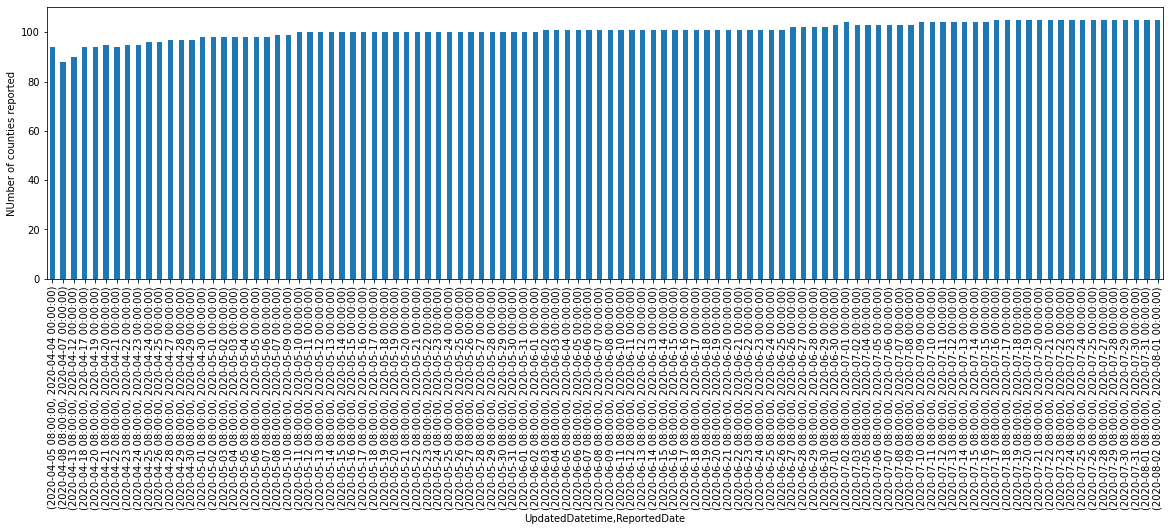

In [7]:
with open('./Data/Total_Count/all_dates_count_df.json','r') as f:
    all_dates_count_df = pd.read_json(f,convert_dates=['ReportedDate', 'UpdatedDatetime'])
#all_dates_count_df = all_dates_count_df[all_dates_count_df['ReportedDate'] != '2020-07-16'] 
#all_dates_count_df = all_dates_count_df[all_dates_count_df['UpdatedDatetime'] != pd.to_datetime('2020-06-28', format='%Y/%m/%d')]
#all_dates_count_df.to_json('./Data/Total_Count/all_dates_count_df.json')
#all_dates_count_df


ax = all_dates_count_df.groupby(['UpdatedDatetime','ReportedDate'])['TotalCount'].count().plot(kind='bar', figsize=(20,5))
_ = ax.set_ylabel('NUmber of counties reported')
#If the number is more than 101, then file is added twice somehow!. If double counted, deleted them with the two commented lines above

### Old way of doing things

from filecmp import cmp
from pathlib import Path

def get_only_unique_pdf(pdfs):
    # get only unique pdfs
    unique_pdfs = [pdfs[0]]
    for file in pdfs[1:]:
        duplicate = False
        for uf in unique_pdfs:
            duplicate |= cmp(file, uf, shallow=True)
        if not duplicate:
            unique_pdfs.append(file)
    return unique_pdfs
    

curr_dir = Path('.')
pdfs = list(curr_dir.glob('**/covid19_in_sd_*.pdf'))
pdfs.sort(key=os.path.getmtime)
unique_pdfs = get_only_unique_pdf(pdfs)

print(unique_pdfs)
    

### Remove unncessary pdf files if there are  any duplicates

import os
for pdf in pdfs:
    if pdf not in unique_pdfs:
        os.remove(pdf)
        
! ls *.pdf 

### Read the pdf and clean up the data

all_dates_count_data = []   
for pdf in unique_pdfs:
    count_data = tabula_convert_pdf_to_df(pdf)
    total_count = count_data['TotalCount'].unique()[0]
    updated_date = count_data['UpdatedDatetime'].iloc[0].to_pydatetime()
    reported_date = count_data['ReportedDate'].iloc[0].to_pydatetime()
    title = f'Date through {reported_date:%Y-%m-%d}, Updated on {updated_date:%Y-%m-%d %I:%M %p}'
    print(f'{title}, TotalCount: {total_count}')
    all_dates_count_data.append(count_data)
all_dates_count_df = pd.concat(all_dates_count_data)

all_dates_count_df = all_dates_count_df.sort_values(by='ReportedDate', ascending=False).reset_index(drop=True)
all_dates_count_df

### Store the data

all_dates_count_df.to_json('all_dates_count_df.json')

In [8]:
count_data

,ZipCode,CaseCount,RatePer100000,TotalCount,ReportedDate,UpdatedDatetime
0,91901,78,433.7,29883,2020-08-01,2020-08-02 08:00:00
1,91902,171,969.9,29883,2020-08-01,2020-08-02 08:00:00
2,91905,6,Unknown,29883,2020-08-01,2020-08-02 08:00:00
3,91906,16,Unknown,29883,2020-08-01,2020-08-02 08:00:00
4,91910,1243,1482.7,29883,2020-08-01,2020-08-02 08:00:00
...,...,...,...,...,...,...
47,92145,7,Unknown,29883,2020-08-01,2020-08-02 08:00:00
48,92154,1819,2273.9,29883,2020-08-01,2020-08-02 08:00:00
49,92173,974,3594.5,29883,2020-08-01,2020-08-02 08:00:00
50,92536,1,Unknown,29883,2020-08-01,2020-08-02 08:00:00
